In [4]:
import torch
import pandas as pd
import numpy as np

from torch import tensor
from transformers import pipeline
from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz

In [2]:
class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs,
                       attention_mask=torch.ones_like(inputs))
        return pred[position]

    def visualize(self, inputs: list, attributes: list, prediction: list, text: str, truth: str, delta: tensor):
       """
            Visualize the weights of inputs
       """ 
       all_tokens = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0])

       attr_sum = attributes.sum(-1) 
       attr = attr_sum / torch.norm(attr_sum)
       df_weights = pd.Series(np.round(attr.numpy()[0], 2), index = all_tokens)

       score_vis = viz.VisualizationDataRecord(
                        word_attributions = attr[0],
                        pred_prob = prediction[0]['score'],
                        pred_class = prediction[0]['label'],
                        true_class = truth,
                        attr_class = text,
                        attr_score = attr[0].sum(),       
                        raw_input_ids = all_tokens,
                        convergence_score = delta)
       viz.visualize_text([score_vis])
       
       ax = df_weights.plot.barh(figsize=(10,3))
       ax.bar_label(ax.containers[0])
                      
    def explain(self, text: str, truth: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline.predict(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, getattr(self.__pipeline.model, 'distilbert').embeddings)
        
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = self.__pipeline.model.config.label2id[prediction[0]['label']], 
                                  return_convergence_delta = True)
        self.visualize(inputs, attributes, prediction, text, truth, delta)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)
    


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
POSITIVE,POSITIVE (1.00),I am very excited about this project,1.21,i am very excited about this project


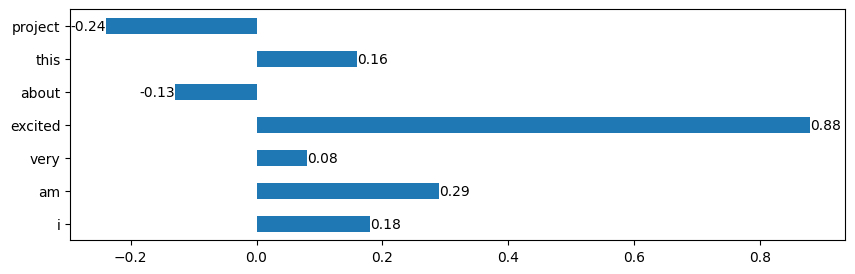

In [3]:
device = "cpu"
sample = "I am very excited about this project"
truth = "POSITIVE"
pipe = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")
exp_model = ExplainableTransformerPipeline(name="distilbert", pipeline=pipe, device=device)
exp_model.explain(sample, truth)